Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на несколько вопросов.

## Задачи:

1. Сколько у нас пользователей, которые совершили покупку только один раз?

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. 

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. 

## Файлы:

1. olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей

    * customer_id — позаказный идентификатор пользователя

    * customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

    * customer_zip_code_prefix —  почтовый индекс пользователя

    * customer_city —  город доставки пользователя

    * customer_state —  штат доставки пользователя
    

2. olist_orders_dataset.csv —  таблица заказов

    * order_id —  уникальный идентификатор заказа (номер чека)

    * customer_id —  позаказный идентификатор пользователя

    * order_status —  статус заказа:
             * created —  создан
             * approved —  подтверждён
             * invoiced —  выставлен счёт
             * processing —  в процессе сборки заказа
             * shipped —  отгружен со склада
             * delivered —  доставлен пользователю
             * unavailable —  недоступен
             * canceled —  отменён
          
    * order_purchase_timestamp —  время создания заказа

    * order_approved_at —  время подтверждения оплаты заказа

    * order_delivered_carrier_date —  время передачи заказа в логистическую службу

    * order_delivered_customer_date —  время доставки заказа

    * order_estimated_delivery_date —  обещанная дата доставки
    

3. olist_order_items_dataset.csv —  товарные позиции, входящие в заказы

    * order_id —  уникальный идентификатор заказа (номер чека)

    * order_item_id —  идентификатор товара внутри одного заказа

    * product_id —  ид товара (аналог штрихкода)

    * seller_id — ид производителя товара

    * shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

    * price —  цена за единицу товара

    * freight_value —  вес товара

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors
from datetime import datetime
from IPython.display import Image

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['image.cmap'] = 'viridis'

In [2]:
# customers — таблица с уникальными идентификаторами пользователей
customers = pd.read_csv('olist_customers_dataset.csv')

# orders — таблица заказов
orders = pd.read_csv('olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp', 
                                                             'order_approved_at',
                                                             'order_delivered_carrier_date',
                                                             'order_delivered_customer_date',
                                                             'order_estimated_delivery_date'])

# items — товарные позиции, входящие в заказы
items = pd.read_csv('olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])

In [3]:
def showing(data):
    print('Количество дубликатов:', data.duplicated().sum())
    print('Количество пропусков:', data.isnull().sum())

In [4]:
print('orders')
print(showing(orders))
print()
print('items')
print(showing(items))
print()
print('customers')
print(showing(customers))

orders
Количество дубликатов: 0
Количество пропусков: order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64
None

items
Количество дубликатов: 0
Количество пропусков: order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64
None

customers
Количество дубликатов: 0
Количество пропусков: customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
None


В таблице заказов есть пропущенные значения в столбцах "время подтверждения оплаты заказа", "время передачи заказа в логистическую службу" и "время доставки заказа". Вероятно, не все заказы были доставлены до пункта назначения.

## 1. Сколько пользователей, совершивших покупку только один раз?

 Для начала, нам нужно определить, что мы будем считать покупкой. Посмотрев на данные по статусам заказа, кажется логичным отбросить заказы со статусом "canceled" и "unavailable".
В наших данных также есть заказы, которые считаются отмененными или недоступными, но при этом есть факт оплаты (время подтверждения). Однако, такие заказы могли быть оплачены и после отменены, а сам товар возвращен, как и деньги владельцу. Поэтому в данном случае будем считать, что все отмененные и недоступные заказы не являются покупкой.
Также для более удобного восприятия создадим отдельный столбец, где будет указано, было ли по заказу указано время оплаты (время оплаты указано означает, что деньги были внесены и такой заказ можно считать  покупкой).

In [5]:
orders['paid_order'] = orders.order_approved_at.notna()

In [6]:
# Таблица с покупками

purchases_df = orders[(orders.order_status != 'unavailable') & 
                     (orders.order_status != 'canceled') & 
                     (orders.paid_order == True)]

In [7]:
purchases_df.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,paid_order
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,True
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,True
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,True


Далее соединим наш новый датафрейм purchases, в котором указаны только настоящие покупки, с таблицей customers для того, чтобы получить уникальные идентификаторы пользователей.

In [8]:
purchases = purchases_df[['order_id', 'customer_id']] \
    .merge(customers[['customer_id', 'customer_unique_id']], on='customer_id', how='left')

In [9]:
purchases.head()

,order_id,customer_id,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6


In [10]:
showing(purchases)

Количество дубликатов: 0
Количество пропусков: order_id              0
customer_id           0
customer_unique_id    0
dtype: int64


Для того, чтобы найти количество пользователей, которые совершили только одну покупку, нужно таблицу purchases сгруппировать по уникальному идентификатору пользователя и посчитать количество его совершенных заказов. После отфильтровать только тех пользователей, у которых количество заказов равняется 1

In [11]:
one_purchase = purchases.groupby('customer_unique_id', as_index=False) \
    .agg({'customer_id': 'count'}) \
    .rename(columns={'customer_id': 'order_amount'}) \
    .query('order_amount == 1')

one_purchase.head()

,customer_unique_id,order_amount
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [12]:
print('{}% всех пользователей совершили только одну покупку. Количество уникальных пользователей, которые совершили покупку только один раз — {}' \
      .format(round(100 * one_purchase.shape[0] / purchases.customer_unique_id.nunique(), 2),\
      one_purchase.shape[0]))

96.96% всех пользователей совершили только одну покупку. Количество уникальных пользователей, которые совершили покупку только один раз — 92087


## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

В данном случае нам для начала также стоит определиться с тем, какой заказ мы считаем не доставленным. 
 
1) Заказ отменен (т.е. "order_status == canceled"), однако при этом не было даты доставки до покупателя, т.е. когда покупатель просто отменил свой заказ. Предполагается, что данный товар после был благополучно возвращен на склад.

2) Заказ недоступен (т.е. "order_status == unavailable"). Т.к. у нас также нет данных по их датам выгрузки со склада или датам доставки до покупателя.

3) Ошибка в данных. Заказы, которые указаны, как "доставлен", однако нет даты доставки.

In [13]:
# Создадим новый датафрейм, у которого на месте индекса будут даты создания заказа

orders_with_timeindex = orders.set_index('order_purchase_timestamp')
orders_with_timeindex.head()

,order_id,customer_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,paid_order
order_purchase_timestamp,,,,,,,,
2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,True
2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,True
2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,True
2017-11-18 19:28:06,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,True
2018-02-13 21:18:39,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,True


#### 2.1) Oтмененные заказы

In [14]:
canceled_orders= orders_with_timeindex[(orders_with_timeindex.order_status == 'canceled') & 
                                       (orders_with_timeindex.order_delivered_customer_date.isna())] \
                                       .resample("M").order_id.count().reset_index() \
                                       .rename(columns={'order_id': 'canceled_order_amount'})
canceled_orders.head()

,order_purchase_timestamp,canceled_order_amount
0,2016-09-30,2
1,2016-10-31,19
2,2016-11-30,0
3,2016-12-31,0
4,2017-01-31,3


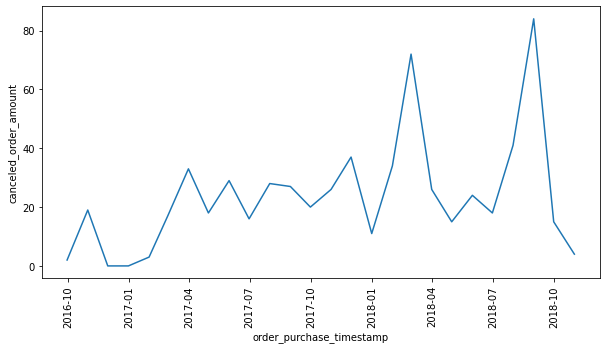

In [15]:
plt.xticks(rotation=90)
sns.lineplot(x='order_purchase_timestamp', y='canceled_order_amount', data=canceled_orders);

#### 2.2) Недоступные заказы

In [16]:
unavailable_orders = orders_with_timeindex[orders_with_timeindex.order_status == 'unavailable'] \
                            .resample("M").order_id.count().reset_index() \
                            .rename(columns={'order_id': 'unavailable_order_amount'})
unavailable_orders.head()

,order_purchase_timestamp,unavailable_order_amount
0,2016-10-31,7
1,2016-11-30,0
2,2016-12-31,0
3,2017-01-31,10
4,2017-02-28,45


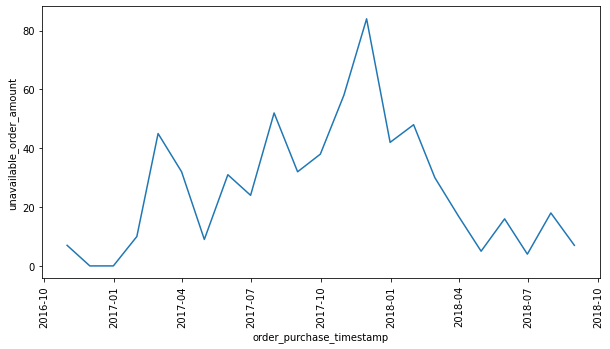

In [17]:
plt.xticks(rotation=90)
sns.lineplot(x='order_purchase_timestamp', y='unavailable_order_amount', data=unavailable_orders);

#### 2.3) Ошибка в данных

In [18]:
bugged_orders = orders_with_timeindex[(orders_with_timeindex.order_status == 'delivered') & 
                      (orders_with_timeindex.order_delivered_customer_date.isna())] \
                      .resample("M").order_id.count().reset_index() \
                      .rename(columns={'order_id': 'bugged_order_amount'})
bugged_orders.head()

,order_purchase_timestamp,bugged_order_amount
0,2017-05-31,1
1,2017-06-30,0
2,2017-07-31,0
3,2017-08-31,0
4,2017-09-30,0


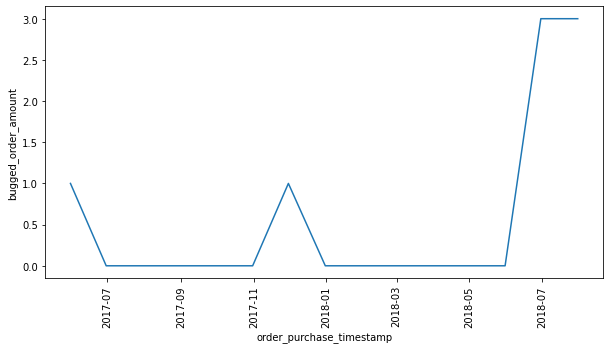

In [19]:
plt.xticks(rotation=90)
sns.lineplot(x='order_purchase_timestamp', y='bugged_order_amount', data=bugged_orders);

In [20]:
print('Среднее для отмененных заказов - ', round(canceled_orders.canceled_order_amount.mean(), 2))
print('Среднее для недоступных заказов - ', round(unavailable_orders.unavailable_order_amount.mean(), 2))
print('Среднее для заказов с ошибками в данных - ', round(bugged_orders.bugged_order_amount.mean(), 2))

Среднее для отмененных заказов -  23.81
Среднее для недоступных заказов -  26.48
Среднее для заказов с ошибками в данных -  0.53


## 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [21]:
# Возьмём только колонки с идентификаторами заказа и товара из таблицы items

products = items[['product_id', 'order_id']]

# Соединим таблицу products с таблицей purchases для того, чтобы отобрать только реальные покупки
# и добавим колонку с названием недели, когда была произведена покупка

items_with_dates = products.merge(purchases_df[['order_id', 'order_approved_at']], on='order_id')
items_with_dates['day_of_week'] = items_with_dates.order_approved_at.dt.day_name()
items_with_dates.head()

,product_id,order_id,order_approved_at,day_of_week
0,4244733e06e7ecb4970a6e2683c13e61,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 09:45:35,Wednesday
1,e5f2d52b802189ee658865ca93d83a8f,00018f77f2f0320c557190d7a144bdd3,2017-04-26 11:05:13,Wednesday
2,c777355d18b72b67abbeef9df44fd0fd,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:48:30,Sunday
3,7634da152a4610f1595efa32f14722fc,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:10:18,Wednesday
4,ac6c3623068f30de03045865e4e10089,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 14:10:13,Saturday


In [22]:
# Для того, чтобы найти в какой день недели товар чаще всего покупается, нам нужно найти день, 
# который встречается чаще всего, т.е. моду данного значения

products_with_most_freq_days = items_with_dates.groupby('product_id', as_index=False) \
                                               .agg({'day_of_week': pd.Series.mode})

products_with_most_freq_days.head()

,product_id,day_of_week
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Friday
3,000b8f95fcb9e0096488278317764d19,"[Friday, Wednesday]"
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday


## 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [23]:
# Для удобства сделаем отдельный датафрейм, который является соединением таблицы customers и purchases

users_df = customers[['customer_id', 'customer_unique_id']] \
    .merge(purchases_df[['customer_id', 'order_approved_at']], \
           on='customer_id')

# Также добавим 2 колонки: месяц покупки и количество недель в месяце

users_df['month'] = users_df.order_approved_at.dt.month_name()
users_df['weeks_in_month'] = round(users_df.order_approved_at.dt.days_in_month / 7, 2)

users_df.head()

,customer_id,customer_unique_id,order_approved_at,month,weeks_in_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:22:12,May,4.43
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:58:32,January,4.43
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,2018-05-20 16:19:10,May,4.43
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 17:29:19,March,4.43
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 10:10:09,July,4.43


In [24]:
# Найдем количество покупок для каждого пользователя по месяцам

order_amount_by_users = users_df.groupby(['customer_unique_id', 'month'], as_index=False) \
        .agg({'customer_id': 'count'}) \
        .rename(columns={'customer_id': 'order_amount'}) \
        .sort_values('customer_unique_id')

order_amount_by_users.head()

,customer_unique_id,month,order_amount
0,0000366f3b9a7992bf8c76cfdf3221e2,May,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,May,1
2,0000f46a3911fa3c0805444483337064,March,1
3,0000f6ccb0745a6a4b88665a16c9f078,October,1
4,0004aac84e0df4da2b147fca70cf8255,November,1


In [25]:
# Найдем общее количество недель в месяц для каждого пользователя по месяцам

weeks_in_month_by_users = users_df.groupby(['customer_unique_id', 'month'], as_index=False) \
                                  .agg({'weeks_in_month': 'sum'})

weeks_in_month_by_users.head()

,customer_unique_id,month,weeks_in_month
0,0000366f3b9a7992bf8c76cfdf3221e2,May,4.43
1,0000b849f77a49e4a4ce2b2a4ca5be3f,May,4.43
2,0000f46a3911fa3c0805444483337064,March,4.43
3,0000f6ccb0745a6a4b88665a16c9f078,October,4.43
4,0004aac84e0df4da2b147fca70cf8255,November,4.29


In [26]:
# Объединим данные

weekly_purchases_in_month_by_users = order_amount_by_users.merge(weeks_in_month_by_users, on=['customer_unique_id', 'month'])
weekly_purchases_in_month_by_users.head()

,customer_unique_id,month,order_amount,weeks_in_month
0,0000366f3b9a7992bf8c76cfdf3221e2,May,1,4.43
1,0000b849f77a49e4a4ce2b2a4ca5be3f,May,1,4.43
2,0000f46a3911fa3c0805444483337064,March,1,4.43
3,0000f6ccb0745a6a4b88665a16c9f078,October,1,4.43
4,0004aac84e0df4da2b147fca70cf8255,November,1,4.29


In [27]:
# Посчитаем для каждого пользователя среднее количество покупок в неделю

weekly_purchases_in_month_by_users['avg_purchases_per_week'] = round(weekly_purchases_in_month_by_users.order_amount \
                                                                     / weekly_purchases_in_month_by_users.weeks_in_month, 2)

In [28]:
 weekly_purchases_in_month_by_users.head()

,customer_unique_id,month,order_amount,weeks_in_month,avg_purchases_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,May,1,4.43,0.23
1,0000b849f77a49e4a4ce2b2a4ca5be3f,May,1,4.43,0.23
2,0000f46a3911fa3c0805444483337064,March,1,4.43,0.23
3,0000f6ccb0745a6a4b88665a16c9f078,October,1,4.43,0.23
4,0004aac84e0df4da2b147fca70cf8255,November,1,4.29,0.23


## 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц.

 Для того, чтобы провести когортный анализ, нужно:   
 
 1) Выявить когорту пользователей. В нашем случае мы будем делить наших пользователей по месяцу покупки.  
 2) Интервал времени, в течение которого считается метрика. Это будет месяц.  
 3) Метрика, которая считается. Мы будем считать retention, т.е. количество пользователей, которые вернулись к нашему продукту через N-ое количество дней (в нашем случае, через месяц) после первой покупки.

In [29]:
# Возьмем датафрейм users_df с предыдущего задания и уберем лишние колонки 

users_df_cohort = users_df[['customer_unique_id', 'customer_id', 'order_approved_at']]
users_df_cohort.head()

,customer_unique_id,customer_id,order_approved_at
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:22:12
1,290c77bc529b7ac935b93aa66c333dc3,18955e83d337fd6b2def6b18a428ac77,2018-01-12 20:58:32
2,060e732b5b29e8181a18229c7b0b2b5e,4e7b3e00288586ebd08712fdd0374a03,2018-05-20 16:19:10
3,259dac757896d24d7702b9acbbff3f3c,b2b6027bc5c5109e529d4dc6358b12c3,2018-03-13 17:29:19
4,345ecd01c38d18a9036ed96c73b8d066,4f2d8ab171c80ec8364f7c12e35b23ad,2018-07-29 10:10:09


In [30]:
# Создадим 2 колонки: год-месяц покупки конкретного заказа и самая первая покупка для конкретного пользователя

users_df_cohort['order_month'] = users_df_cohort['order_approved_at'].dt.to_period('M')
users_df_cohort['cohort'] = users_df_cohort.groupby('customer_unique_id')['order_approved_at'] \
                                           .transform('min').dt.to_period('M')
users_df_cohort.head()

,customer_unique_id,customer_id,order_approved_at,order_month,cohort
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:22:12,2017-05,2017-05
1,290c77bc529b7ac935b93aa66c333dc3,18955e83d337fd6b2def6b18a428ac77,2018-01-12 20:58:32,2018-01,2018-01
2,060e732b5b29e8181a18229c7b0b2b5e,4e7b3e00288586ebd08712fdd0374a03,2018-05-20 16:19:10,2018-05,2018-05
3,259dac757896d24d7702b9acbbff3f3c,b2b6027bc5c5109e529d4dc6358b12c3,2018-03-13 17:29:19,2018-03,2018-03
4,345ecd01c38d18a9036ed96c73b8d066,4f2d8ab171c80ec8364f7c12e35b23ad,2018-07-29 10:10:09,2018-07,2018-07


In [31]:
# Сгруппируем данные по когорте и год-месяцу покупки заказа и посчитаем количество уникальных пользователей

cohort = users_df_cohort.groupby(['cohort', 'order_month']) \
                        .agg({'customer_id': pd.Series.nunique}) \
                        .rename(columns={'customer_id': 'num_customers'}) \
                        .reset_index()

# Посчитаем сколько прошло месяцев между первой покупкой и датой покупки заказа
cohort['period_number'] = (cohort.order_month - cohort.cohort).apply(attrgetter('n'))
cohort.head()

,cohort,order_month,num_customers,period_number
0,2016-09,2016-09,1,0
1,2016-10,2016-10,294,0
2,2016-10,2017-04,1,6
3,2016-10,2017-07,1,9
4,2016-10,2017-09,1,11


In [32]:
# Трансформируем нашу таблицу так, чтобы в индексах были наши когорты, в столбцах — период после первой покупки,
# в значениях — количество уникальных пользователей, пришедших на данный период после первой покупки

cohort_pivot = cohort.pivot_table(index='cohort',
                                     columns='period_number',
                                     values='num_customers')
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,294.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,2.0
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,749.0,4.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,2.0,2.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0,NaN
2017-02,1699.0,4.0,4.0,3.0,7.0,2.0,4.0,3.0,1.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,5.0,NaN,NaN
2017-03,2620.0,14.0,9.0,11.0,9.0,4.0,4.0,8.0,8.0,3.0,10.0,3.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN,NaN
2017-04,2332.0,15.0,6.0,5.0,6.0,6.0,9.0,6.0,8.0,4.0,5.0,2.0,2.0,1.0,2.0,2.0,4.0,NaN,NaN,NaN
2017-05,3612.0,20.0,18.0,14.0,11.0,15.0,17.0,5.0,9.0,11.0,10.0,12.0,8.0,2.0,8.0,10.0,NaN,NaN,NaN,NaN
2017-06,3169.0,14.0,12.0,12.0,8.0,11.0,11.0,7.0,4.0,7.0,10.0,11.0,5.0,4.0,7.0,NaN,NaN,NaN,NaN,NaN


Для того, чтобы посчитать retention, нам нужно поделить каждую ячейку на его первое значение в строке, к которой он принадлежит. Также у нас имеются значения NaN в первых трех строках и также в середине 4-ой строки. Они появились из-за того, что на этот период не было вновь вернувшихся посетителей.

In [33]:
# Возьмем в отдельную переменную первые значения строк, 
# поделим значения ячейки на соответствующие им значения 
# и получим таблицу retention

cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0).mul(100).round(2)

In [34]:
# Заполним ненужные значения NaN нулем

retention_matrix.iloc[0] = retention_matrix.iloc[0].fillna(0)
retention_matrix.iloc[1] = retention_matrix.iloc[1].fillna(0)
retention_matrix.iloc[2] = retention_matrix.iloc[2].fillna(0)
retention_matrix.iloc[3, 9] = 0

In [35]:
# Укажем максимальное значение в каждом столбце

retention_matrix.style.highlight_max()

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-10,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.340000,0.000000,0.000000,0.340000,0.000000,0.340000,0.000000,0.340000,0.000000,0.340000,0.000000,0.340000,0.680000,0.680000
2016-12,100.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01,100.000000,0.530000,0.270000,0.130000,0.400000,0.130000,0.400000,0.130000,0.130000,0.000000,0.270000,0.270000,0.670000,0.400000,0.130000,0.130000,0.270000,0.400000,0.130000,nan
2017-02,100.000000,0.240000,0.240000,0.180000,0.410000,0.120000,0.240000,0.180000,0.060000,0.180000,0.120000,0.290000,0.120000,0.180000,0.120000,0.060000,0.060000,0.290000,nan,nan
2017-03,100.000000,0.530000,0.340000,0.420000,0.340000,0.150000,0.150000,0.310000,0.310000,0.110000,0.380000,0.110000,0.230000,0.110000,0.150000,0.230000,0.080000,0.150000,nan,nan
2017-04,100.000000,0.640000,0.260000,0.210000,0.260000,0.260000,0.390000,0.260000,0.340000,0.170000,0.210000,0.090000,0.090000,0.040000,0.090000,0.090000,0.170000,nan,nan,nan
2017-05,100.000000,0.550000,0.500000,0.390000,0.300000,0.420000,0.470000,0.140000,0.250000,0.300000,0.280000,0.330000,0.220000,0.060000,0.220000,0.280000,nan,nan,nan,nan
2017-06,100.000000,0.440000,0.380000,0.380000,0.250000,0.350000,0.350000,0.220000,0.130000,0.220000,0.320000,0.350000,0.160000,0.130000,0.220000,nan,nan,nan,nan,nan


По таблице видно, что в промежутке январь-декабрь когорта с наивысшим retention на 3-й месяц является "2017-09" — 0,43%.
Если предположить, что мы продаем товары ежедневного потребления или, по крайней мере, не редкие товары, то такой показатель retention очень маленький даже для когорты с наивысшим показателем. Впрочем, уже на начальной стадии было видно, что у нас довольно много покупателей, которые совершили только одну покупку, поэтому мы наблюдаем такую картину.

## 6. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время.

In [36]:
# Для начала сгруппируем данные в таблице items по каждому заказу (order_id) и посчитаем полную сумму заказа

orders_grouped_by_price = items.groupby('order_id', as_index=False) \
     .agg({'price': 'sum'})

# и соединим полученные данные с таблицей реальных покупок purchases

orders_grouped_by_price = orders_grouped_by_price.merge(purchases_df[['order_id', 'customer_id']],
                                                        on='order_id',
                                                        how='inner')

# и уже эти данные соединим с таблицей users_df чтобы собрать всё в одном месте

temp_rfm_df = users_df.merge(orders_grouped_by_price, 
                          on='customer_id')

In [37]:
# Отбросим ненужные колонки

temp_rfm_df = temp_rfm_df.drop(['month', 'weeks_in_month', 'order_id'], 
                         axis=1)
temp_rfm_df.head()

,customer_id,customer_unique_id,order_approved_at,price
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:22:12,124.99
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:58:32,289.00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,2018-05-20 16:19:10,139.94
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 17:29:19,149.94
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 10:10:09,230.00


Для того, что провести RFM-анализ, нужно определить параметры recency (R), frequency (F) и monetary (M).  
В нашем случае:  
1) R - время от последней покупки пользователя до текущей даты.  
2) F - суммарное количество покупок у пользователя за всё время.   
3) M - сумма покупок за всё время  

In [38]:
# Введем переменную, которая будет определять текущий день

TODAY = datetime.today()

In [39]:
# Создадим колонку, которая будет показывать количество дней, прошедших с даты заказа до текущего дня

temp_rfm_df['days_since_order'] = temp_rfm_df['order_approved_at'].apply(lambda x: (TODAY - x).days)

temp_rfm_df.head()

,customer_id,customer_unique_id,order_approved_at,price,days_since_order
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:22:12,124.99,2202
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:58:32,289.00,1961
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,2018-05-20 16:19:10,139.94,1833
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 17:29:19,149.94,1901
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 10:10:09,230.00,1763


In [40]:
# Создадим новый датафрейм, где сгруппируем данные по уникальному пользователю и посчитаем r, m и f

rfm_df = temp_rfm_df.groupby('customer_unique_id', as_index=False) \
                    .agg({'days_since_order': 'min',
                          'customer_id': 'count',
                          'price': 'sum'}) \
                    .rename(columns={'days_since_order': 'recency',
                                     'customer_id': 'frequency',
                                     'price': 'monetary'})
rfm_df.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,1843,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1846,1,18.90
2,0000f46a3911fa3c0805444483337064,2269,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,2053,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,2020,1,180.00


Чтобы понять, на сколько сегментов делить каждый параметр, взглянем на распределение каждого из параметров, а также на их квантили.

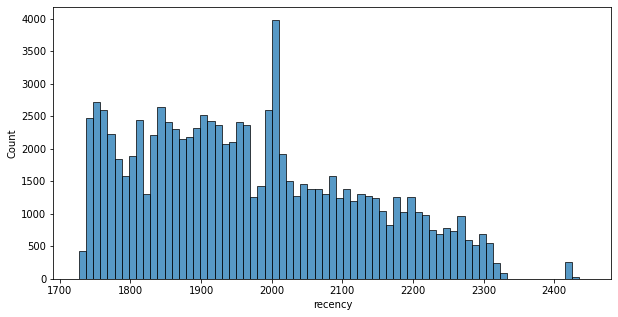

In [41]:
sns.histplot(rfm_df.recency);

In [42]:
rfm_df.recency.quantile([.2, .4, .6, .8])

0.2    1824.0
0.4    1908.0
0.6    1999.0
0.8    2115.0
Name: recency, dtype: float64

In [43]:
rfm_df.recency.quantile([.33, .66])

0.33    1879.0
0.66    2018.0
Name: recency, dtype: float64

Можно взять 33-й и 66-квантили и разделить данный параметр на 3 категории:  

    1 — от 2015    
    2 — от 1876 до 2015 дней    
    3 — до 1876 дней

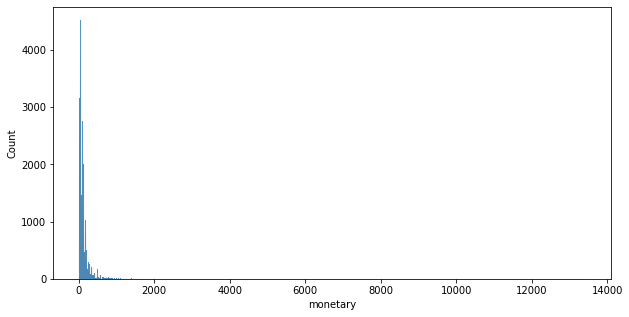

In [44]:
sns.histplot(rfm_df.monetary);

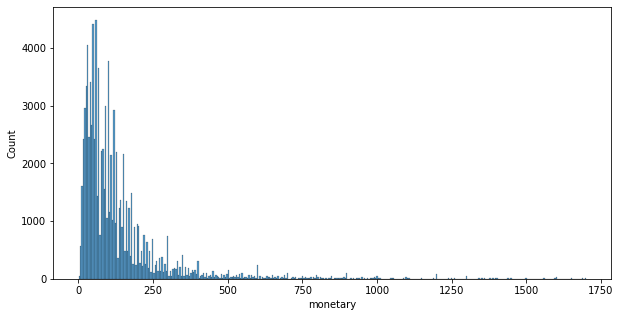

In [45]:
sns.histplot(rfm_df[rfm_df.monetary < 1700].monetary);

In [46]:
rfm_df.monetary.quantile([.2, .4, .6, .8, .9, .95, .99])

0.20      39.900
0.40      69.900
0.60     109.900
0.80     179.900
0.90     281.249
0.95     420.000
0.99    1004.990
Name: monetary, dtype: float64

По графику видно, что распределение не нормальное и большая часть покупок не превышает сумму 250. В данном случае, кажется оптимальным вариантом взять также 3 категории:   

    1 - пользователи до 90-го квантиля (сумма до 281) 
    2 - от 90 до 99-го (сумма от 281 до 1004) 
    3 -свыше 99-го квантиля (сумма свыше 1004).

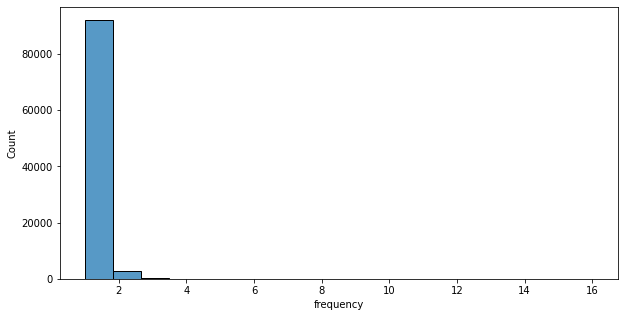

In [47]:
sns.histplot(rfm_df.frequency);

In [48]:
rfm_df.frequency.value_counts()

1     92084
2      2650
3       188
4        29
5         9
6         5
7         3
16        1
9         1
Name: frequency, dtype: int64

Большая часть пользователей совершили одну покупку. Параметр можно разделить на следующие подгруппы:  

    1 - одна покупка; 
    2 - две покупки;
    3 - 3 или 4 покупки; 
    4 - больше 5 покупок.

In [49]:
# Для этого создадим словарь с квантилями для параметров "recency" и "monetary"

quintiles = dict()
quintiles['recency'] = rfm_df['recency'].quantile([.33, .66]).to_dict()
quintiles['monetary'] = rfm_df['monetary'].quantile([.90, .99]).to_dict()
quintiles

{'recency': {0.33: 1879.0, 0.66: 2018.0},
 'monetary': {0.9: 281.24900000000287, 0.99: 1004.99}}

**Чем выше оценка по "recency", тем меньше времени прошло с последней покупки.  
Чем выше оценка по "monetary", тем большую сумму клиент потратил на заказы.  
Чем выше оценка по "frequency", тем больше заказов сделал клиент.**

In [50]:
def r_score(x):
    if x <= quintiles['recency'][.33]:
        return 3
    elif x <= quintiles['recency'][.66]:
        return 2
    else:
        return 1

def m_score(x):
    if x <= quintiles['monetary'][.9]:
        return 1
    elif x <= quintiles['monetary'][.99]:
        return 2
    else:
        return 3
    
def f_score(x):
    if x == 1:
        return 1
    elif x == 2:
        return 2
    elif x ==3 or x == 4:
        return 3
    else:
        return 4

In [51]:
# Добавляем в нашу таблицу значения вышепосчитанных параметров

rfm_df['R'] = rfm_df['recency'].apply(lambda x: r_score(x))
rfm_df['F'] = rfm_df['frequency'].apply(lambda x: f_score(x))
rfm_df['M'] = rfm_df['monetary'].apply(lambda x: m_score(x))

rfm_df['RFM Score'] = rfm_df['R'].map(str) + rfm_df['F'].map(str) + rfm_df['M'].map(str)

rfm_df.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM Score
0,0000366f3b9a7992bf8c76cfdf3221e2,1843,1,129.90,3,1,1,311
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1846,1,18.90,3,1,1,311
2,0000f46a3911fa3c0805444483337064,2269,1,69.00,1,1,1,111
3,0000f6ccb0745a6a4b88665a16c9f078,2053,1,25.99,1,1,1,111
4,0004aac84e0df4da2b147fca70cf8255,2020,1,180.00,1,1,1,111


На данном этапе наших пользователей нужно разделить на разные кластеры в зависимости от параметров "recency" и "frequency" (дальше "r" - recency, "f" - frequency):  

1) r = 1, f = 1 or 2 — 'highly likely lost' (покупали давно и делали всего лишь 1 или 2 заказа)  
2) r = 1, f = 3 — 'at risk' (покупали 3-4 раза, но последняя активность была также давно)  
3) r = 1, f = 4 — 'can't lose them' (покупали чаще всех, но очень давно)  
4) r = 2 or 3, f = 1 — 'promising' (относительно недавно пришедшие пользователи, но всего лишь с одной покупкой)  
5) r = 2, f = 2 — 'about to sleep' (недавние пользователи с частотой покупок ниже среднего)  
6) r = 3, f = 2 — 'need attention' ("свежие пользователи" с нечастыми покупками)  
7) r = 2 or 3, f = 3 — 'potential loyalists' (относительно новые клиенты, которые покупают чуть больше среднего)  
8) r = 2, f = 4 — 'loyal customers' (относительно новые клиенты, покупают чаще всех)  
9) r = 3, f = 4 — 'champions' (самые последние покупатели, которые покупали больше всего)

In [52]:
# Создаем словарь с такими же ключами и значениями

segt_map = {
    r'1[12]': 'highly likely lost',
    r'13': 'at risk',
    r'14': 'can\'t lose them',
    r'[23]1': 'promising',
    r'22': 'about to sleep',
    r'32': 'need attention',
    r'[23]3': 'potential loyalist',
    r'24': 'loyal customers',
    r'34': 'champions'
}

In [53]:
# Создадим отдельную колонку, используя метод "replace" и регулярные выражения
# Теперь каждый клиент зачислен в отдельный кластер в зависимости от его значений "frequency" и "recency"

rfm_df['Segment'] = rfm_df['R'].map(str) + rfm_df['F'].map(str)
rfm_df['Segment'] = rfm_df['Segment'].replace(segt_map, regex=True)
rfm_df.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,1843,1,129.90,3,1,1,311,promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1846,1,18.90,3,1,1,311,promising
2,0000f46a3911fa3c0805444483337064,2269,1,69.00,1,1,1,111,highly likely lost
3,0000f6ccb0745a6a4b88665a16c9f078,2053,1,25.99,1,1,1,111,highly likely lost
4,0004aac84e0df4da2b147fca70cf8255,2020,1,180.00,1,1,1,111,highly likely lost


Распределение данных показателей в виде матрицы выглядит следующим образом:

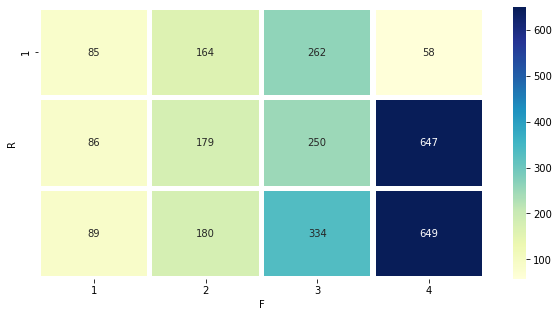

In [54]:
rfm_table = rfm_df.pivot_table(
                        index='R', 
                        columns='F', 
                        values='monetary', 
                        aggfunc=np.median).applymap(int)
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4);

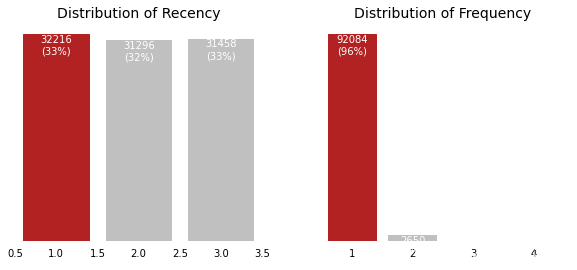

In [55]:
# Распределение пользователей по значенияим "recency" и "frequency"

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = rfm_df[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

Картина не новая, распределение по "recency" довольно ровное, в то время как по "frequency" ясно, что больше всего клиентов, совершивших один заказ.

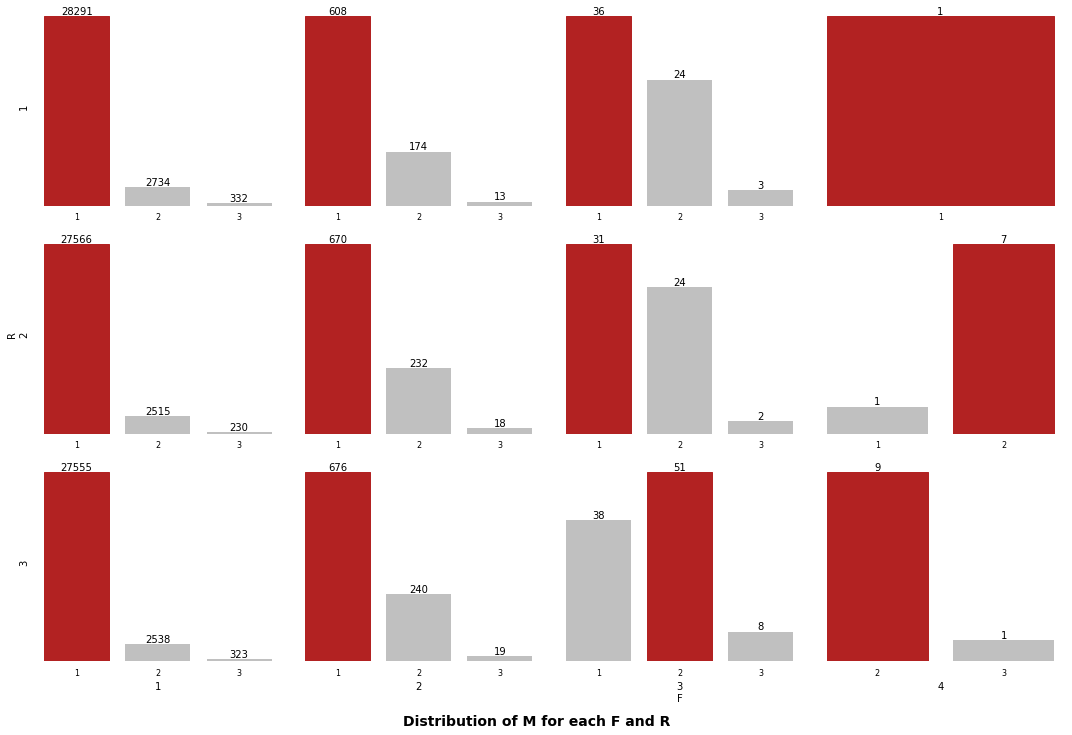

In [56]:
# Распределение параметра "monetary" по RF-значениям

fig, axes = plt.subplots(nrows=3, ncols=4,
                         sharex=False, sharey=False,
                         figsize=(15, 10))

r_range = range(1, 4)
f_range = range(1, 5)
for r in r_range:
    for f in f_range:
        y = rfm_df[(rfm_df['R'] == r) & (rfm_df['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 3:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 2:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14,
            fontweight='bold',
            x=0.5, y=0)
plt.tight_layout()
plt.show()

Заметно, что для значений F = 3 и F = 4 пользователей очень мало. Поведение остальных пользователей для F = 1 и F = 2 по разным значениям R отличается слабо: большинство клиентов совершили одну покупку (F = 1) и сумма покупки не превышала 281 д.е. (M = 1)

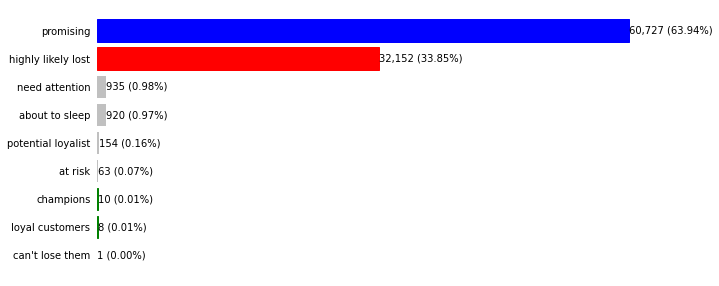

In [57]:
# Количество пользователей для каждого кластера

segments_counts = rfm_df['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('green')
        elif segments_counts.index[i] == 'highly likely lost':
            bar.set_color('red')
        elif segments_counts.index[i] == 'promising':
            bar.set_color('blue')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:.2f}%)'.format(int(value),
                                   float(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

Большая часть (~ 60%) наших пользователей находится в категории "promising" (r = 2 or 3, f = 1) и 32% в категории "highly likely lost" (r = 1, f = 1 or 2).

Распределив клиентов по сегментам и представив некоторые статистические данные о составе нашего клиентского портфеля, мы можем работать над целевыми маркетинговыми кампаниями, чтобы удержать клиентов, находящихся в группе риска, хотя, возможно, стоит прекратить (или минимизировать) попытки повлиять на аудиторию (маркетинг и т.д.), которую мы скорее всего уже потеряли, так как пытаясь их задействовать, мы будем впустую тратить ресурсы.   

Скорее стоит улучшить продажи потенциальным и действующим клиентам, которые попадают под категории "promising" и "highly likely lost": предлагать скидку или бонус на следующую покупку / за покупку от определённой суммы / ограниченные по времени акции и поработать над рекомендательной системой.